# 時系列解析6 1時間後　結構うまく行く
https://qiita.com/mix_dvd/items/ecfa6f0038e39cdce57e

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.layers import Input, merge
from keras.layers import Merge
from utils import save_model_viz, save_weights, save_hist, plot_hist2
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


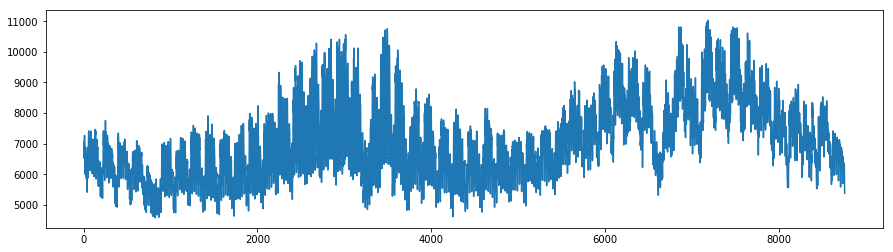

In [3]:
df_kw = pd.read_csv("data/juyo-2017.csv",encoding="Shift_JIS",skiprows=1)
df_kw["MW"] = df_kw["実績(万kW)"] * 10

df_kw["DATETIME"] = df_kw.index.map(lambda x: pd.to_datetime(df_kw.DATE[x] + " " + df_kw.TIME[x]))

# 可視化
df_kw["MW"].plot(figsize=(15,4))

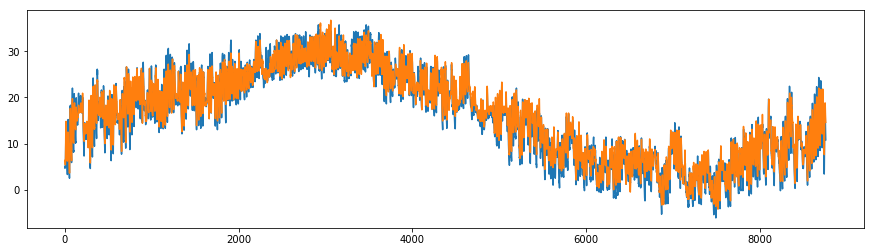

In [4]:
def read_temp(filename):
    df_temp = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_temp.columns = ["DATETIME","TEMP","品質情報","均質番号"]
    df_temp.DATETIME = df_temp.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_temp

# 岡山
df_temp_okym = read_temp("data/data_okayama-2017.csv")
df_temp_okym.rename(columns = {'TEMP':'TEMP_okym'}, inplace=True)

# 広島
df_temp_hrsm = read_temp("data/data_hiroshima-2017.csv")
df_temp_hrsm.rename(columns = {'TEMP':'TEMP_hrsm'}, inplace=True)

# 可視化
df_temp_okym.TEMP_okym.plot(figsize=(15,4))
df_temp_hrsm.TEMP_hrsm.plot(figsize=(15,4))

In [5]:
len(df_temp_okym), len(df_temp_hrsm),len(df_kw)

(8760, 8760, 8760)

In [6]:
# データの複製
df = df_kw.copy()
# 岡山の気温を結合
df = df.merge(df_temp_okym,how="inner", on="DATETIME")
# 広島の気温を結合
df = df.merge(df_temp_hrsm,how="inner", on="DATETIME")

df = df.dropna()

In [7]:
print(df.MW.mean(), df.TEMP_okym.mean(), df.TEMP_hrsm.mean())
print(df.MW.std(), df.TEMP_okym.std(), df.TEMP_hrsm.std())

7105.1786733645395 15.711485329375469 16.354424021006995
1243.3727995382856 9.511011061918847 9.128966280809285


In [8]:
df_MW = (df.MW - df.MW.mean())/df.MW.std()
df_TEMP_okym =  (df.TEMP_okym - df.TEMP_okym.mean())/df.TEMP_okym.std()
df_TEMP_hrsm =  (df.TEMP_hrsm - df.TEMP_hrsm.mean())/df.TEMP_hrsm.std()

In [9]:
print(df_MW.mean(), df_TEMP_okym.mean(), df_TEMP_hrsm.mean())
print(df_MW.std(), df_TEMP_okym.std(), df_TEMP_hrsm.std())

5.569240695967591e-16 2.852762361688383e-15 -2.8559565185807858e-15
0.9999999999999958 1.0000000000000044 0.9999999999999978


In [10]:
def create_dataset(y, x1, x2,  steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(y)-steps_of_history, steps_in_future):
        X.append([[y[i:i+steps_of_history]] ,[x1[i:i+steps_of_history]], [x2[i:i+steps_of_history]]])  
        Y.append(y[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, 3, steps_of_history]).transpose(0,2,1)
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 3
steps_in_future = 1

X, Y = create_dataset(df_MW, df_TEMP_okym, df_TEMP_hrsm, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.33)

In [11]:
print(trainX.shape, trainY.shape,  testX.shape, testY.shape)

(5867, 3, 3) (5867, 1) (2889, 3, 3) (2889, 1)


In [12]:
df_MW[0:5], df_TEMP_okym[0:5] , df_TEMP_hrsm[0:5], trainX[0],trainY[0]

(0   -0.406297
 1   -0.205231
 2   -0.036336
 3   -0.116762
 4   -0.349999
 Name: MW, dtype: float64, 0   -1.157762
 1   -1.147248
 2   -1.136734
 3   -1.115705
 4   -1.126219
 Name: TEMP_okym, dtype: float64, 0   -1.101376
 1   -1.090422
 2   -1.112330
 3   -1.134238
 4   -1.156147
 Name: TEMP_hrsm, dtype: float64, array([[-0.40629703, -1.1577618 , -1.10137596],
        [-0.20523102, -1.14724768, -1.09042182],
        [-0.03633558, -1.13673355, -1.1123301 ]]), array([-0.11676198]))

In [13]:
CLS_LR = 0.0001
BATCHSIZE = 128
epochs = 600
np.random.seed(1234)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=0.000001)

model = Sequential()
model.add(LSTM(64, return_sequences=False,
                     input_shape=(steps_of_history,3)))
# model_x.add(LSTM(64,return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))


model.compile(loss='mean_squared_error',optimizer=Adam(lr=CLS_LR))

model.summary()

hist = model.fit(trainX, trainY,
              batch_size=BATCHSIZE,
              epochs=epochs,
              verbose=1,
              validation_data=(testX, testY),
              shuffle=True, callbacks=[reduce_lr])
                   
RUN_ID = 'LSTM1'
save_model_viz(RUN_ID, model)
save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Train on 5867 samples, validate on 2889 samples
Epoch 1/600
5867/5867 [==============================] - 1s 102us/step - loss: 0.8353 - val_loss: 1.0817
Epoch 2/600
5867/5867 [==============================] - 0s 38us/step - loss: 0.7311 - val_loss: 1.0498
Epoch 3/600
5867/5867 [==============================] - 0s 38us/step - loss: 0.6305 - val_loss: 1.0194
Epoch 4/600
5867/5867 [==================

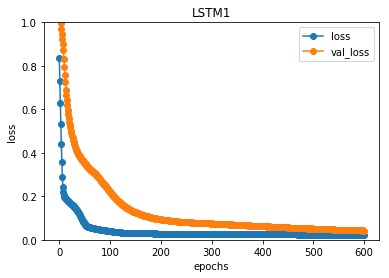

In [14]:
plot_hist2(RUN_ID)

KERAS REG RMSE : 256.14


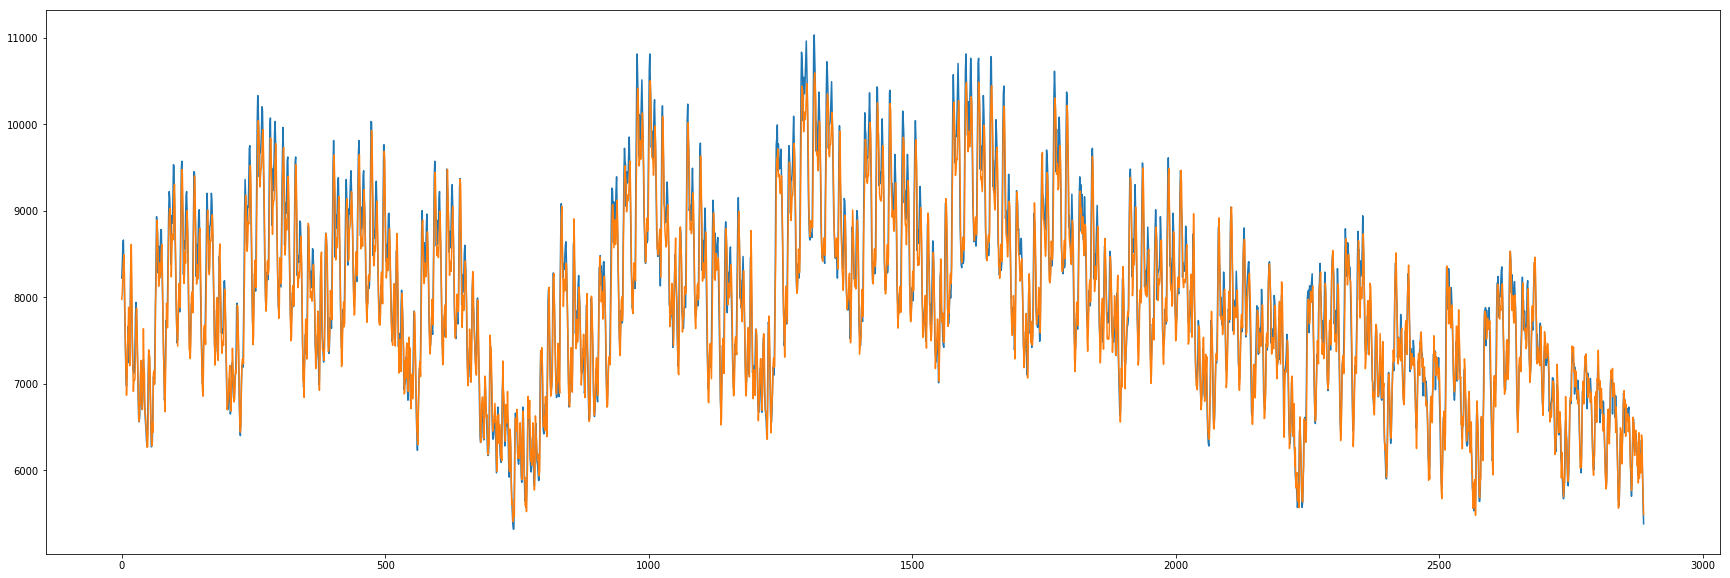

In [15]:
# 二乗平方根で誤差を算出
from sklearn.metrics import mean_squared_error

# 予測値の取得
y_pred = model.predict(testX)
mse = mean_squared_error(testY*df.MW.std() + df.MW.mean(),y_pred*df.MW.std() + df.MW.mean() )
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

# 可視化
plt.figure(figsize=(30, 10))
plt.plot(testY*df.MW.std() + df.MW.mean(), label='truth')
plt.plot(y_pred*df.MW.std() + df.MW.mean() , label='pred')

# 2017年から2018年を予測

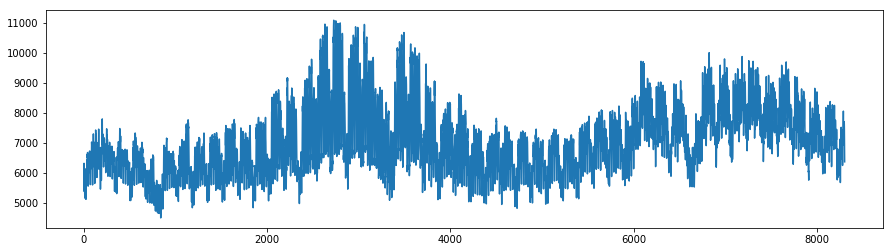

In [16]:
df_kw_18 = pd.read_csv("data/juyo-2018.csv",encoding="Shift_JIS",skiprows=1)
df_kw_18["MW"] = df_kw_18["実績(万kW)"] * 10

df_kw_18["DATETIME"] = df_kw_18.index.map(lambda x: pd.to_datetime(df_kw_18.DATE[x] + " " + df_kw_18.TIME[x]))

# 可視化
df_kw_18["MW"].plot(figsize=(15,4))

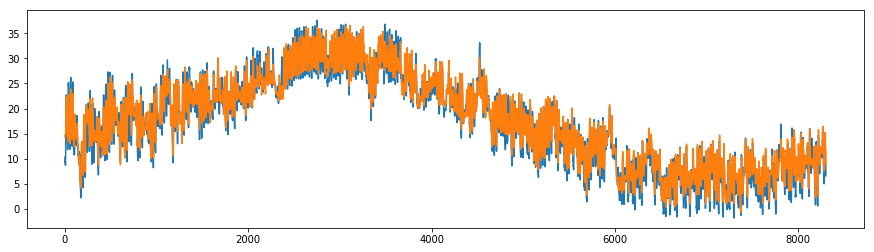

In [17]:
def read_temp(filename):
    df_temp = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_temp.columns = ["DATETIME","TEMP","品質情報","均質番号"]
    df_temp.DATETIME = df_temp.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_temp

# 岡山
df_temp_okym_18 = read_temp("data/data_okayama-2018.csv")
df_temp_okym_18.rename(columns = {'TEMP':'TEMP_okym'}, inplace=True)

# 広島
df_temp_hrsm_18 = read_temp("data/data_hiroshima-2018.csv")
df_temp_hrsm_18.rename(columns = {'TEMP':'TEMP_hrsm'}, inplace=True)

# 可視化
df_temp_okym_18.TEMP_okym.plot(figsize=(15,4))
df_temp_hrsm_18.TEMP_hrsm.plot(figsize=(15,4))

In [18]:
# データの複製
df_18 = df_kw_18.copy()
# 岡山の気温を結合
df_18= df_18.merge(df_temp_okym_18,how="inner", on="DATETIME")
# 広島の気温を結合
df_18 = df_18.merge(df_temp_hrsm_18,how="inner", on="DATETIME")

df_18 = df_18.dropna()

In [19]:
df_MW_18 = (df_18.MW - df_18.MW.mean())/df_18.MW.std()
df_TEMP_okym_18 =  (df_18.TEMP_okym - df_18.TEMP_okym.mean())/df_18.TEMP_okym.std()
df_TEMP_hrsm_18 =  (df_18.TEMP_hrsm - df_18.TEMP_hrsm.mean())/df_18.TEMP_hrsm.std()

In [20]:
def create_dataset(y, x1, x2,  steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(y)-steps_of_history, steps_in_future):
        X.append([[y[i:i+steps_of_history]] ,[x1[i:i+steps_of_history]], [x2[i:i+steps_of_history]]])  
        Y.append(y[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, 3, steps_of_history]).transpose(0,2,1)
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 3
steps_in_future = 1

X_18, Y_18 = create_dataset(df_MW_18, df_TEMP_okym_18, df_TEMP_hrsm_18, steps_of_history, steps_in_future)

KERAS REG RMSE : 213.38


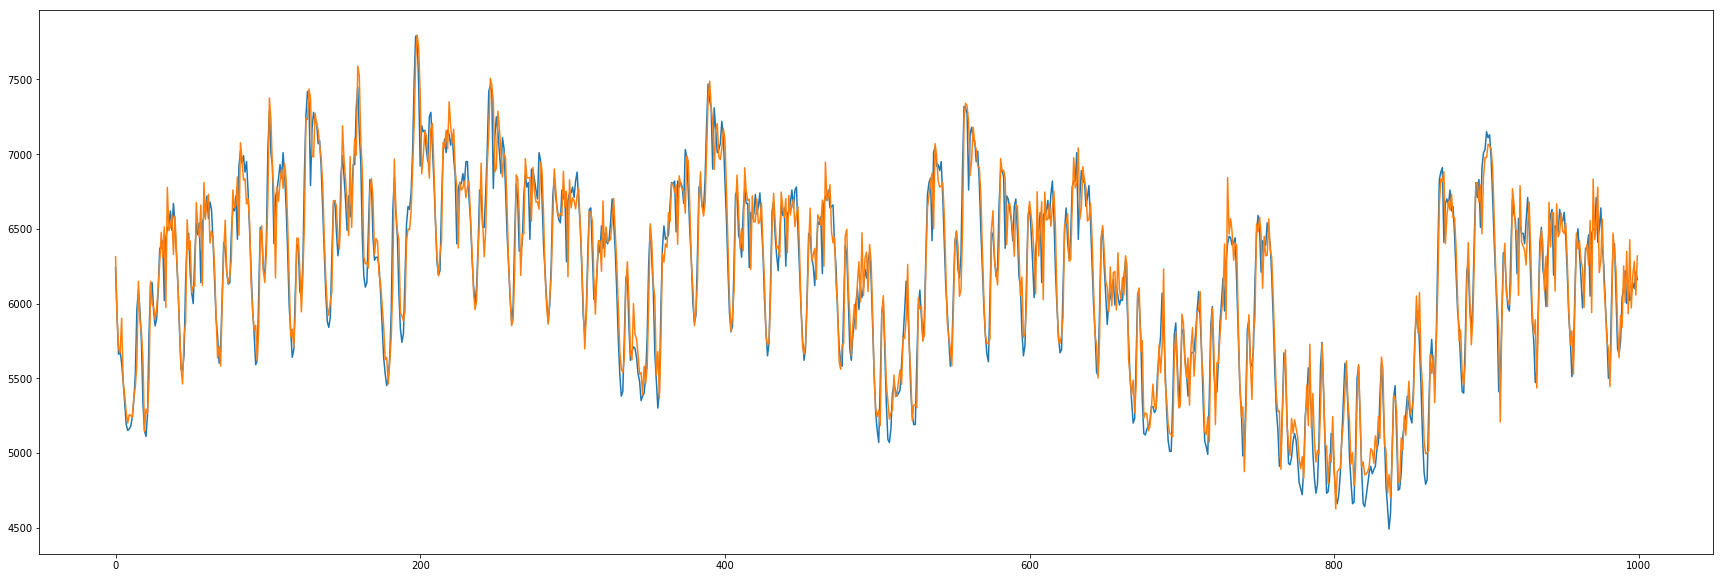

In [21]:
# 二乗平方根で誤差を算出
from sklearn.metrics import mean_squared_error

# 予測値の取得
y_pred_18 = model.predict(X_18)
mse = mean_squared_error(Y_18*df_18.MW.std() + df_18.MW.mean(),y_pred_18*df_18.MW.std() + df_18.MW.mean() )
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

# 可視化
plt.figure(figsize=(30, 10))
plt.plot(Y_18[0:1000]*df_18.MW.std() + df_18.MW.mean(), label='truth')
plt.plot(y_pred_18[0:1000]*df_18.MW.std() + df_18.MW.mean() , label='pred')

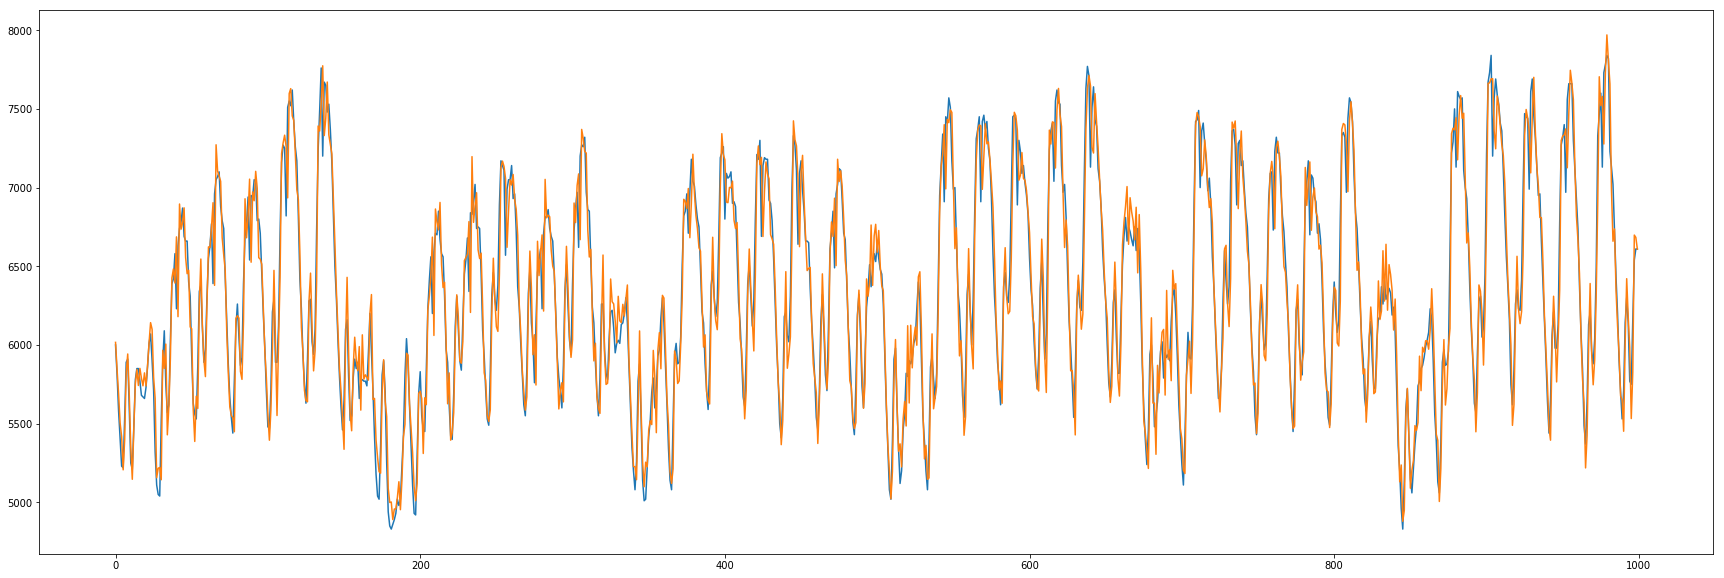

In [22]:
plt.figure(figsize=(30, 10))
plt.plot(Y_18[1000:2000]*df_18.MW.std() + df_18.MW.mean(), label='truth')
plt.plot(y_pred_18[1000:2000]*df_18.MW.std() + df_18.MW.mean() , label='pred')